# Mask statistics (regionprops) #
This notebook shows how can we extract statistical information from an image (e.g. finding the maximal intensity in a desired region of interest). The steps that we need to follow to achieve this mainly depend on the exact problem we want to solve but in general it consists of: 

    Step 1: load and read the image (load-data.ipynb)
    Step 2: pre-process the image if necessary such as noise filtering (filter-image.ipynb)
    Step 3: find the region of interest: edge or inside the region? 
    Step 4: extract the desired information in the region of interest: mean, max, min, sum, median, mode, ...
    Step 5: display/plot results
    Step 6: save the plots in a given image format or values in a text/excel file

## Load image ##

In [1]:
# LOAD PACKAGES
from scyjava import config          # for AICSImage
from aicsimageio import AICSImage   # for reading the image
import numpy as np                  # for operations on arrays
import matplotlib.pyplot as plt     # for plotting/display 
import cv2                          # for generating random noise with a given distribution

In [3]:
# LOAD DATA
mydata=AICSImage("C:/Users/Dina Ratsimandresy/Documents/MRC-Office/Dataset/PythonCourse precious images/Airy_4color_40nm_67e5micron_diversoformato-confocal.tif")
myimg = mydata.data[0,:,0,:,:]  # select all channels at t = 0 and z = 0
imgsize = myimg.shape           # image size

## Display the image ##

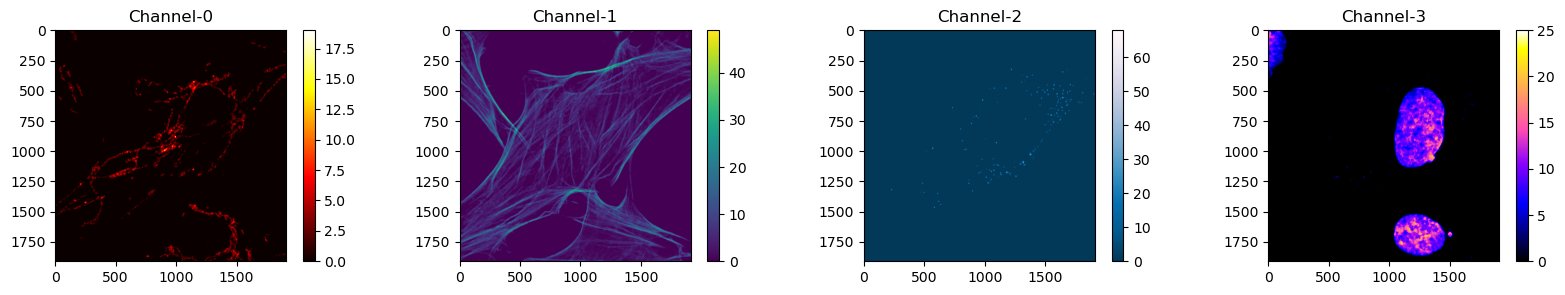

In [4]:
# define the colormap
cmpsuggestion=['hot','viridis','PuBu_r','gnuplot2']
# display each channel
fig, axs = plt.subplots(1, 4)
for k in range(4):
    ax1=axs[k].imshow(myimg[k,:,:], plt.colormaps[cmpsuggestion[k]])    
    axs[k].set_title('Channel-'+str(k))
    plt.colorbar(ax1,ax=axs[k]) 
fig.set_size_inches(20, 3)

# display the combined channel

## Define the problem ##
We need to define a problem here. Let say we are interested in what is happening in each channel in the same region as where the nucleus is. Our region of interest (ROI) is therefore defined by the region delimited by the nucleus in Channel-3. We want to measure:
- the maximal intensity in Channel-0 within this ROI,
- the integrated intensity in Channel-1 within this ROI,
- the median intensity of Channel-2 of the ROI within this ROI  

That is enough problem for now so let's get into it :)

## Segmentation of the region of interest (ROI) ##
In finding the ROI, the main goal is to find a mask delimited by the nucleus. The easiest way to do this by simply thresholding the image. By this, the mask is defined such that only intensity (pixel) values greater than the threshold values are selected. If we stop at this stage, the problem we may encounter is such that some values within the nuclei may get discarded because the intensity value is lower than the threshold. In this case, we may need to find the edge or/and fill the mask region. Another issue that we may encounter as well is that the edges of two distincts objects may overlap so two or more objects may be detected or segmented as one. One solution in this case is to use what is called watershed segmentation to detect the flow of the intensity and decide from there whether the objects form only one object or different objects. 

### Thresholding segmentation ###

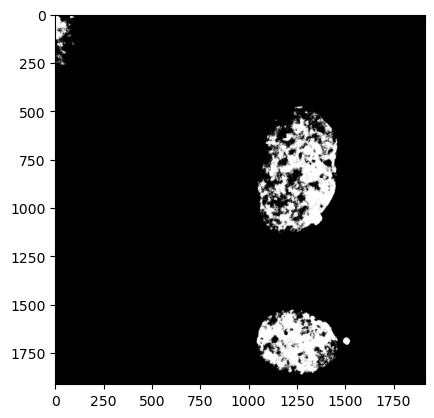

In [165]:
nuclei=myimg[3,:,:] # the object we want to segment 
thresholdmask=nuclei>=10 # change threshold value here to see what happens to the thresholdmask that is being displayed below
plt.imshow(thresholdmask,cmap='gray')
plt.show()

### Region-based segmentation ###
There is also one way to automatically detect the threshold that needs to be applied on the image in order to detect the nuclei region. This method was developed by Otsu and you can follow the link [here](https://en.wikipedia.org/wiki/Otsu%27s_method) if you want to learn more how does it work. So let us see now how can we do the thresholding using the Otsu's method and fill the mask. And since in microscopic images, we may have more than one nulei (in our case we do have 2 full ones), we need to label each of the nucleis to distingush them and to be able to extract information from each of them. To achieve these, we need to load some packages first. 

In [168]:
# PACKAGES
from skimage.filters import threshold_otsu                          # Otsu's threshold
from skimage.morphology import closing, square                      # To close the region we just obtained from the thresholding
from skimage.segmentation import clear_border                       # To remove artifacts connected to image border
from skimage.measure import label, regionprops, find_contours       # To label the nucleis, measure information about regions, find the countours of each region
from skimage.color import label2rgb                                 # To attribute colors to the labelled regions

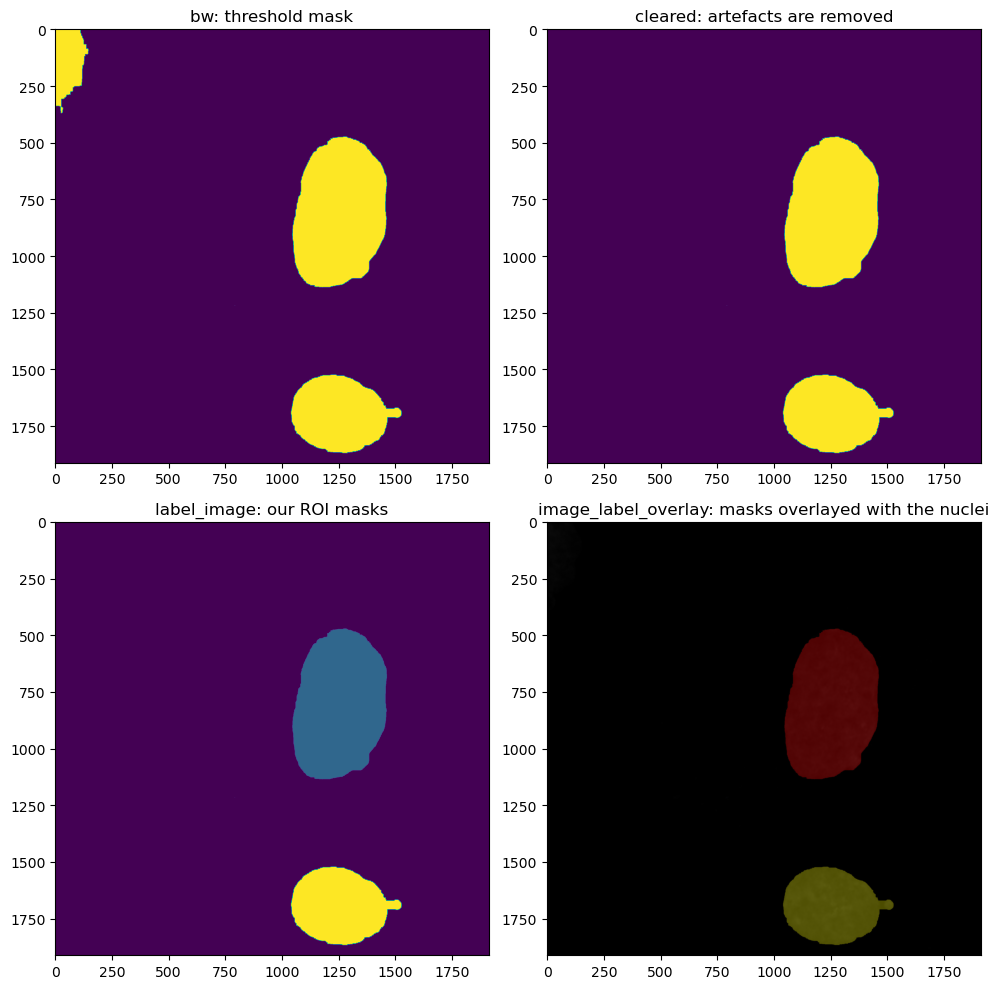

In [293]:
# find the threshold value differentiating the signal from background
thresh = threshold_otsu(nuclei) 

# define the threshold mask and close it
bw = closing(nuclei > thresh, square(35)) 

# remove artifacts connected to image border
cleared = clear_border(bw)

# label image regions
label_image = label(cleared) 

# label image to rgb 
image_label_overlay = label2rgb(label_image, image=nuclei, bg_label=0)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].imshow(bw)
ax[0,0].set_title('bw: threshold mask')

ax[0,1].imshow(cleared)
ax[0,1].set_title('cleared: artefacts are removed')

ax[1,0].imshow(label_image)
ax[1,0].set_title('label_image: our ROI masks')

ax[1,1].imshow(image_label_overlay)
ax[1,1].set_title('image_label_overlay: masks overlayed with the nuclei')


plt.tight_layout()
plt.show()

Measure the properties of the signal within the ROI mask and display the countours of the ROIs only or the countours overlayed with the ROIs

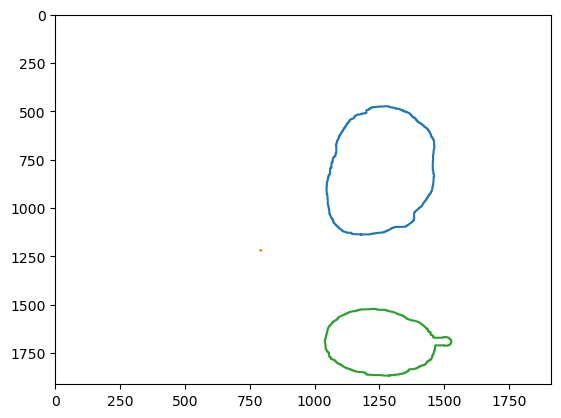

In [289]:
props = regionprops(label_image,nuclei) # signal property: first argument is the mask ROI, second argument is the signal from which we are to extract any information of interest from
# plt.imshow(nuclei) # uncomment if the signal is to be displayed with the mask countours
for p in props:
    c = find_contours(label_image==p.label,0.5)
    plt.plot(c[0][:,1],c[0][:,0])
plt.xlim(0, nuclei.shape[0])
plt.ylim(0, nuclei.shape[1])
plt.gca().invert_yaxis()

## Measurement ##
Now let use the masks (ROI) defined by the nuclei in Channel-3 to do the measurement we previously defined as our problems.
### Measure the maximal intensity in Channel-0 within the ROI ###

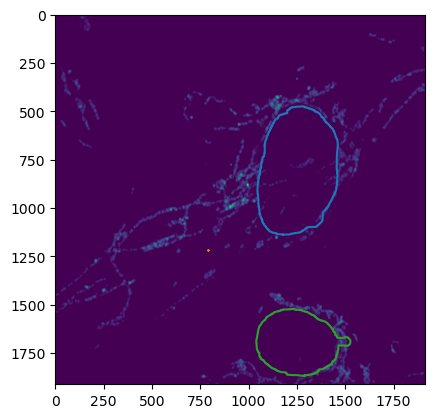

The maximal intensity for each regions are:  [5.0, 0.0, 8.0]


In [236]:
signal = myimg[0,:,:] # the signal from which we want to do the measurement from
props = regionprops(label_image, signal)

# let display them to be sure we are selecting the right mask and the right signal
plt.imshow(signal)
for p in props:
    c = find_contours(label_image==p.label,0.5)
    plt.plot(c[0][:,1],c[0][:,0])
plt.show()

# measure the maximal intensity
list_max_int = [p.intensity_max for p in props]
print('The maximal intensity for each regions are: ',list_max_int)

### Measure the integrated intensity in Channel-1 within the ROI ###
In this measurement, we need to find the integrated intensity within the channel of our interest. It is not straightforward as for calculating the maximal intensity or mean but firstly we need to find the image intensity. Then we sum those intensity values to obtain the integrated intensity. 

Display signal overlayed with the ROI masks


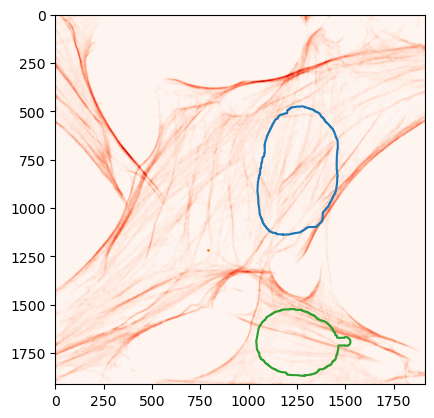

Display image intensity


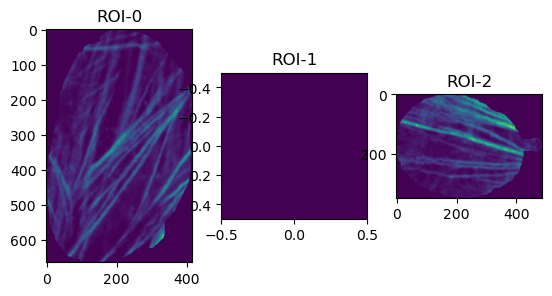

The integrated intensity for each regions are:  [668825, 1, 378966]


In [265]:
signal = myimg[1,:,:] # the signal from which we want to do the measurement from
props = regionprops(label_image, signal)

# let display them to be sure we are selecting the right mask and the right signal
print('Display signal overlayed with the ROI masks')
plt.imshow(signal, cmap='Reds') # just add a Reds colormap into the signal here to differentiate the countour from the signal 
for p in props:
    c = find_contours(label_image==p.label,0.5)
    plt.plot(c[0][:,1],c[0][:,0])
plt.show()

print('Display image intensity')
number_regions = len(props)
fig, axs = plt.subplots(1, number_regions)
k = 0 # initialize the 
list_integrated_int = [] # this the list where we want to store the values of the integrated intensity
for p in props:
    iint = p.image_intensity # extract the image intensity within the ROI
    list_integrated_int.append(np.sum(iint))
    axs[k].imshow(iint)
    axs[k].set_title('ROI-'+str(k))
    k=k+1 
plt.show()
# fig.set_size_inches(10, 1000)

print('The integrated intensity for each regions are: ',list_integrated_int)

### Measure the median intensity in Channel-2 within the ROI ###
The information about the median is also not included in the image property that we can retrieve from regionprops. So here we show how can we do it using the information we can extract from the regionprops and numpy. The median of a list is defined as the middle element of the list when the list is sorted. We will compute a simple list below to illustrate how it works.

In [286]:
# example of median
l=[1,100,5,0,0,200,1000]    # list : change the values if needed
l2=sorted(l)                # sorted list 
print('sorted list: ',l2)   # display the sorted list
print('median value of the list l: ', np.median(l))         # display the median value

sorted list:  [0, 0, 1, 5, 100, 200, 1000]
median value of the list l:  5.0


Display signal overlayed with the ROI masks


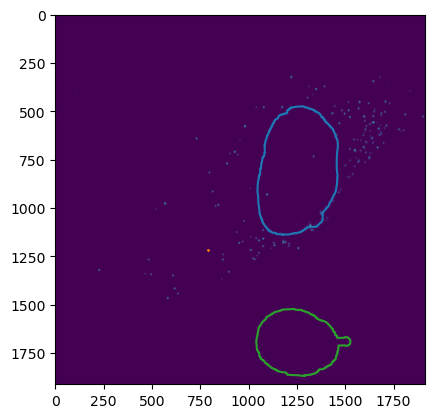

The median intensity for each regions are:  [0.0, 0.0, 0.0]


In [287]:
signal = myimg[2,:,:] # the signal from which we want to do the measurement from
props = regionprops(label_image, signal)

# let display them to be sure we are selecting the right mask and the right signal
print('Display signal overlayed with the ROI masks')
plt.imshow(signal) # the signal from which we want to measure the median 
for p in props:
    c = find_contours(label_image==p.label,0.5)
    plt.plot(c[0][:,1],c[0][:,0])
plt.show()

M=np.arange(len(props)) # indexes of the segmented regions
list_median_int=[np.median(signal[props[m].coords[:,0],props[m].coords[:,1]]) for m in M]

print('The median intensity for each regions are: ',list_median_int)

## Generate a table to display the results ##
Now let save the results! We will need the pandas package for this.

In [295]:
import pandas as pd
plc_data = pd.DataFrame(columns=['Maximal_intensity','Integrated_intensity', 'Median'], dtype=object) # create a table
data = {'Maximal_intensity':list_max_int,'Integrated_intensity': list_integrated_int, 'Median': list_median_int}
plc_data = pd.DataFrame(data=data)
plc_data

,Maximal_intensity,Integrated_intensity,Median
0,30.0,23614,0.0
1,1.0,0,0.0
2,22.0,400,0.0


## Save results in an excel sheet ##

In [300]:
destinationfile='C:/Users/Dina Ratsimandresy/Documents/MRC-Office/Dataset/course/new_discovery.xlsx'
sheet_name='first_try'
plc_data.to_excel(destinationfile, sheet_name, index=False)